In [1]:
import warnings
from collections import Counter
warnings.filterwarnings("ignore")

import pickle
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from ctgan import CTGANSynthesizer
from sklearn.model_selection import train_test_split
from utils import *

MODELS_PATH = './models'
DATA_PATH = './data/'
dataset = 'german'
seed = 1
np.random.seed(seed)

# A. Load data, preprocess, and calculate accuracy 

In [2]:
credit = np.genfromtxt('data/german/german.data-numeric')
X, y = credit[:,:-1], credit[:,-1:].squeeze()

In [3]:
# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.
categorical_features=[]
preprocessor = get_preprocessor(X, categorical_features)
rf = RandomForestClassifier(n_jobs=-1, random_state=seed)

clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', rf)])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

clf.fit(X_train, y_train)
print("model score: %.3f" % clf.score(X_test, y_test))

model score: 0.770


# B. Plot confidence scores for X_train

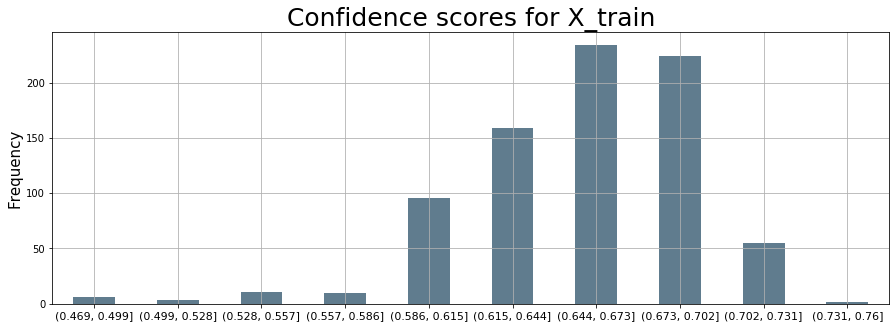

In [31]:
y_prob = rf.predict_proba(X_train)
y_conf_train = y_prob[:, 0]  # confidence scores

plot_confidence_levels(y_conf_train, "Confidence scores for X_train")

# C. Train CTGAN and plot the training loss

Epoch 1, Loss G: 0.6034155897200317, loss_bb: 0.6034155897200317
Epoch 2, Loss G: 0.5731125111108373, loss_bb: 0.5731125111108373
Epoch 3, Loss G: 0.6084561755896164, loss_bb: 0.6084561755896164
Epoch 4, Loss G: 0.6267827173271777, loss_bb: 0.6267827173271777
Epoch 5, Loss G: 0.5874968420921399, loss_bb: 0.5874968420921399
Epoch 6, Loss G: 0.5575580824270557, loss_bb: 0.5575580824270557
Epoch 7, Loss G: 0.5905021325954006, loss_bb: 0.5905021325954006
Epoch 8, Loss G: 0.5907909528435702, loss_bb: 0.5907909528435702
Epoch 9, Loss G: 0.5793208375728099, loss_bb: 0.5793208375728099
Epoch 10, Loss G: 0.6114117813097782, loss_bb: 0.6114117813097782
Epoch 11, Loss G: 0.6245141223077373, loss_bb: 0.6245141223077373
Epoch 12, Loss G: 0.5667641877851289, loss_bb: 0.5667641877851289
Epoch 13, Loss G: 0.6055694822953201, loss_bb: 0.6055694822953201
Epoch 14, Loss G: 0.6102257367852747, loss_bb: 0.6102257367852747
Epoch 15, Loss G: 0.6195639159665277, loss_bb: 0.6195639159665277
Epoch 16, Loss G: 0

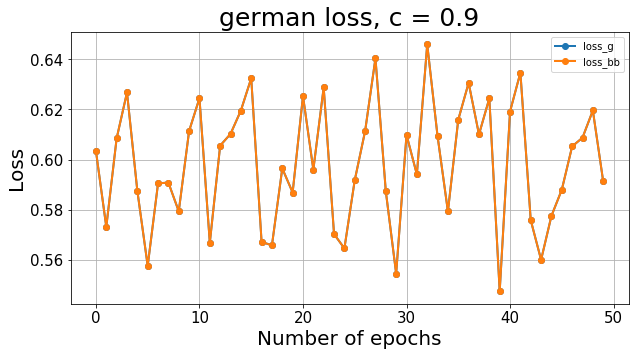

In [5]:
z_features = get_noise_features(X_train, categorical_features)
z_rows = int(0.25 * X_train.shape[0])
z = gen_random_noise(shape=(z_rows, z_features))

batch_size = 50
epochs = 50
confidence_level = 0.9
gen_lr = 2e-5
loss = 'log'

rf_ctgan = CTGANSynthesizer(batch_size=batch_size,
                            blackbox_model=rf,
                            preprocessing_pipeline=preprocessor,
                            bb_loss=loss
                            )

hist = rf_ctgan.fit(train_data=z,
                    epochs=epochs,
                    confidence_level=confidence_level,
                    gen_lr=gen_lr,
                    )

# rf_ctgan.save(f"{MODELS_PATH}/{dataset}_ctgan_c_{confidence_level}.pkl")

plot_losses(hist, title=f'{dataset} loss, c = {confidence_level}')
print()

# D. Plot confidence scores for 100 generated samples 

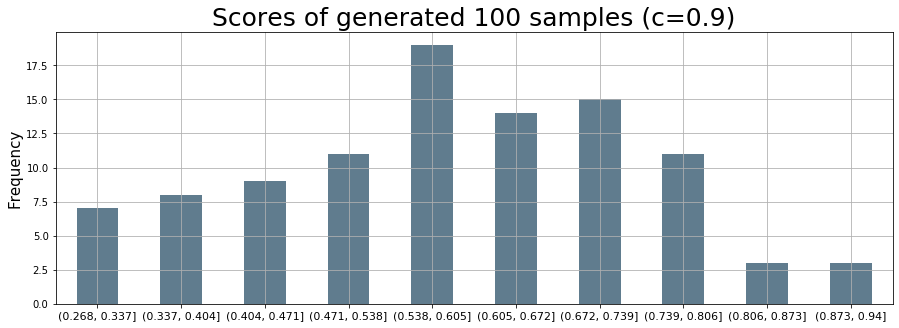

In [13]:
# check confidence for the generated samples
samples = 100

gen_data = rf_ctgan.sample(samples)
y_prob = rf.predict_proba(gen_data)
y_conf_gen = y_prob[:, 0]  # confidence scores

plot_confidence_levels(y_conf_gen, f"Scores of generated {samples} samples (c={confidence_level})")

# E. Find generated samples above the confidence score

In [43]:
# find samples s such that s.confidence > c
indices = np.argwhere(y_conf_gen>confidence_level).squeeze()
print(f"indecies:\n\t{indices}\nconfidence levels:\n\t{y_conf_gen[indices]}")
gen_indices = indices if indecies.shape != () else [indices] # avoide no shape arrays

indecies:
	[28 66]
confidence levels:
	[0.92 0.94]


In [44]:
# inverse the generated data
scaler = get_scaler(preprocessor)
gen_data_above_c_before = gen_data.iloc[gen_indecies]
gen_data_above_c = scaler.inverse_transform(gen_data_above_c_before)
gen_data_above_c = pd.DataFrame(gen_data_above_c).set_index(gen_data_above_c_before.index)

# F. Print most similar examples (X_similiar)

In [45]:
similarities = calc_similarities(gen_data_above_c, X_train)
X_similiar_indices = [el[0] for el in similarities.values()]
print(f"gen_sample_above_c -> (most_similiar_sample_x_train, cosine_score)\n\n{similarities}")

gen_sample_above_c -> (most_similiar_sample_x_train, cosine_score)

{28: (515, 0.998), 66: (586, 0.997)}


# G. Print confidence scores for X_similiar

In [70]:
# extract X_similiar 
X_train_pd = pd.DataFrame(X_train)
X_similiar = X_train_pd.iloc[X_similiar_indices]

# print confidence scores
# y_prob_similar = rf.predict_proba(X_similiar)
# y_conf_similar = y_prob_similar[:, 0]
y_conf_train[X_similiar_indices]

array([0.67, 0.67])

# Plot as table

In [74]:
data = []
for gen_idx, value in similarities.items():
    similar_idx = value[0]
    similarity = value[1]
    gen_conf = y_conf_gen[gen_idx]
    similar_conf = y_conf_train[similar_idx]
    data.append([gen_idx, gen_conf, similar_idx, similar_conf, similarity])

columns = ['gen_idx', 'score', 'sim_idx', 'score', 'similarity']
results = pd.DataFrame(data, columns=columns) 
results

,gen_idx,score,sim_idx,score,similarity
0,28,0.92,515,0.67,0.998
1,66,0.94,586,0.67,0.997
